## LSTM for Anomaly Detection

In this notebook, we explore the idea of using LSTM for anomaly dtection. Before getting our hands dirty, I should mention that first, our dataset is obviously not enough for this type of model and second, we assume that our time-series dataset is normal and predictable to some extent (which is not the case for the stock data).  

We use LSTMs to build a prediction model, i.e. given current and past values, predict next few steps in the time-series. Then, error in prediction gives an indication of anomaly. We define our problem as a regression problem with no anomaly labels. A summary of tasks in this notebook:

- Load and preprocess data for the given ticker
- Define model architecture and training parameters 
- Define loss function and metric (used mean-squared-error to punish outliers more)
- Train the network, logging the validation/training loss and the validation accuracy
- Use the trained model to make predictions on the entire dataset (the same data used for training and validation)
- Calculate and plot error 
- Find index of the records that lie in top or bottom x% (e.g. 0.1%)
- Check for their validity

More resources on this topic can be found [here](https://www.quora.com/How-do-I-use-LSTM-Networks-for-time-series-anomaly-detection).

In [1]:
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

/Users/aravanshad/miniconda2/envs/deeplearning/lib/python3.6/site-packages/h5py/__init__.py:72: UserWarning: h5py is running against HDF5 1.10.1 when it was built against 1.8.4, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


In [2]:
plt.rcParams['figure.figsize'] = [14, 6]
plt.style.use('seaborn-whitegrid')
matplotlib.rc('xtick', labelsize=11) 
matplotlib.rc('ytick', labelsize=11) 

In [3]:
df = pd.read_csv('../Data/sector_joined_closes_train.csv', index_col='Date_Time')
ticker = 'APC'
ticker_data = df[ticker]

# convert our column to pandas series 
series = pd.Series(ticker_data, index=df.index)
series.head()

Date_Time
2017-06-06 13:30:00    49.61
2017-06-06 13:31:00    49.61
2017-06-06 13:32:00    49.55
2017-06-06 13:33:00    49.61
2017-06-06 13:34:00    49.56
Name: APC, dtype: float64

In [4]:
series.isnull().sum()

0

### Preprocessing

In [5]:
def timeseries_to_supervised(data, lag=1, dropnan=True):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    if dropnan:
        df.dropna(inplace=True)
    return df

def difference(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return pd.Series(diff)

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]


In [6]:
# transform data to be stationary
raw_values = series.values.astype('float32')
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train_size = int(len(supervised_values) * 0.7)
train, test = supervised_values[0:train_size], supervised_values[train_size:len(supervised_values)]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

### Build Model

In [7]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons, dropout):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True, dropout=dropout))
    model.add(Dense(1))
    sgd = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
    model.compile(loss='mean_squared_error', optimizer='sgd')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size, verbose=0)
    return yhat[0,0]

In [8]:
# repeat 5 times
repeats = 5
# variable for keep track of error scores
error_scores = list()
for r in range(repeats):
    # let's train
    lstm_model = fit_lstm(train_scaled, 1, 5, 50, 0.4)
    predictions = list()
    # let's predict for test case
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
        # report performance
    rmse = sqrt(mean_squared_error(raw_values[train_size:len(supervised_values)], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)

1) Test RMSE: 0.039
2) Test RMSE: 0.039
3) Test RMSE: 0.039
4) Test RMSE: 0.039
5) Test RMSE: 0.039


In [9]:
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (1, 50)                   10400     
_________________________________________________________________
dense_5 (Dense)              (1, 1)                    51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [10]:
# report performance
results = pd.DataFrame()
results['rmse'] = error_scores
print(results.describe())
# results.boxplot()

           rmse
count  5.000000
mean   0.039010
std    0.000089
min    0.038924
25%    0.038961
50%    0.038984
75%    0.039028
max    0.039155


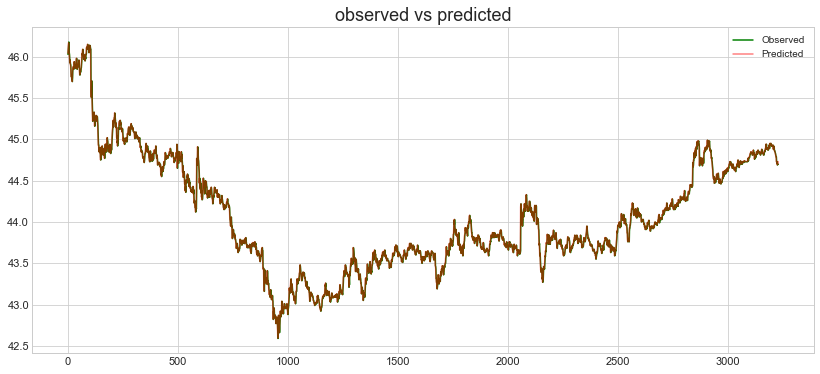

In [11]:
# plot of observed vs predicted
plt.plot(raw_values[train_size:len(supervised_values)], label='Observed', color='g')
plt.plot(predictions, alpha=0.5, label='Predicted', color='r')
plt.legend()
plt.title('observed vs predicted', fontsize=18)
plt.show()

### Run the model on the entire training dataset  

Let's run the model on the entire training dataset and find the ones with the most deviation from the truth.

In [12]:
print (series.iloc[0])

49.61


In [13]:
# first value of our dataset
f = np.array(49.61)
# sklearn minmaxscaler for converting "f" to range to (-1,1)
scaler = MinMaxScaler(feature_range=(-1, 1))
# minmaxscaler fit
scaler = scaler.fit(f)
# let's transform
initial = f.reshape(1, 1)
initial_scaled = scaler.transform(initial)

In [14]:
initial = initial_scaled
prediction = []
for i in range(len(supervised)):
    # predict 
    yhat = forecast_lstm(lstm_model, 1, initial)
    # inverse prediction to it's original value
    yhat_inver = scaler.inverse_transform(yhat)
    # append to our prediction variable
    prediction.append(yhat_inver)
    # re initial our initial variable so that it feed the current predicted value as input for forecast
    initial = np.array([yhat])

In [15]:
y = [[x] for x in supervised.iloc[:,1]]
yhat = prediction

In [16]:
rmse = [[sqrt(mean_squared_error(y[i], yhat[i]))] for i in range(len(y))]

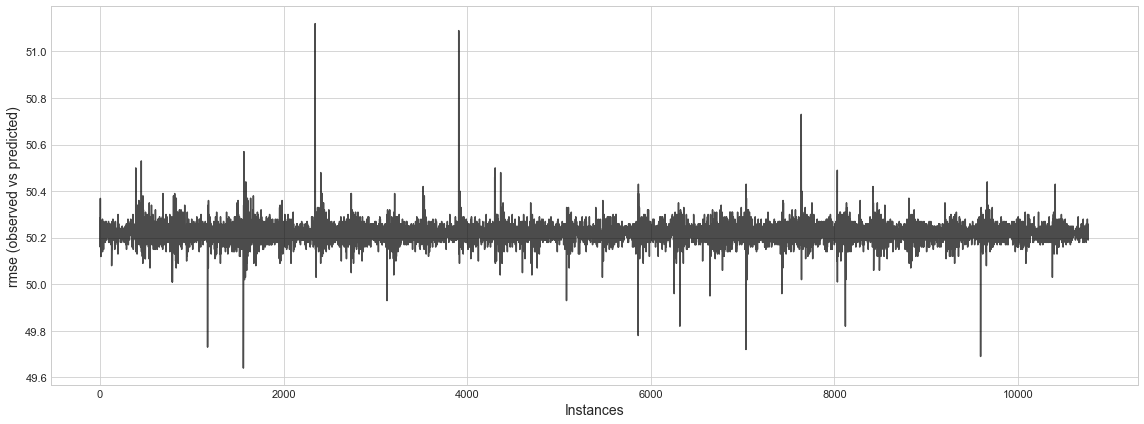

In [34]:
plt.figure(figsize=[16,6])
plt.plot(rmse, color='k', alpha=0.7)
plt.xlabel('Instances', fontsize=14)
plt.ylabel('rmse (observed vs predicted)', fontsize=14)
plt.tight_layout()
plt.savefig('../Figs/lstm_anomaly.pdf', dpi=100)

In [18]:
ulimit = np.percentile(rmse, 99.9)
llimit = np.percentile(rmse, 0.10)
np.around(llimit, decimals=5), np.around(ulimit, decimals=5)

(49.95949, 50.44419)

In [19]:
ixs = pd.to_datetime(series[1:-1].index)
rmse_series = pd.Series(rmse, index=ixs)

In [20]:
anomaly1 = rmse_series.loc[rmse_series>ulimit]
anomaly2 = rmse_series.loc[rmse_series<llimit]

In [21]:
anomaly1

Date_Time
2017-06-07 13:30:00    [50.499488830566406]
2017-06-07 14:30:00     [50.52949142456055]
2017-06-12 13:35:00     [50.56949234008789]
2017-06-13 20:00:00     [51.11949157714844]
2017-06-14 14:30:00    [50.479488372802734]
2017-06-19 20:00:00      [51.0894889831543]
2017-06-21 13:30:00     [50.45948791503906]
2017-06-21 13:35:00    [50.499488830566406]
2017-06-21 14:35:00    [50.479488372802734]
2017-07-05 13:30:00    [50.729488372802734]
2017-07-06 13:32:00     [50.48948669433594]
dtype: object

As can be seen, algorithm has problem with gap in data as it detects the last record of the day and the first record of the next day as anomalies which is reasonable but not true.

In [22]:
anomaly1.between_time('13:30:01','19:59:59')

Date_Time
2017-06-07 14:30:00     [50.52949142456055]
2017-06-12 13:35:00     [50.56949234008789]
2017-06-14 14:30:00    [50.479488372802734]
2017-06-21 13:35:00    [50.499488830566406]
2017-06-21 14:35:00    [50.479488372802734]
2017-07-06 13:32:00     [50.48948669433594]
dtype: object

In [23]:
anomaly2.between_time('13:30:01','19:59:59')

Date_Time
2017-06-28 14:32:00    [49.819488525390625]
2017-07-06 15:00:00    [49.819488525390625]
dtype: object

Now, if we check data for the suggested anomalies, we realize that it is not easy to say if they are in fact anomalies. For example, in the case below, obviously it's not. So, I am not comfortable to use this method as my concern is to remove some useful information.

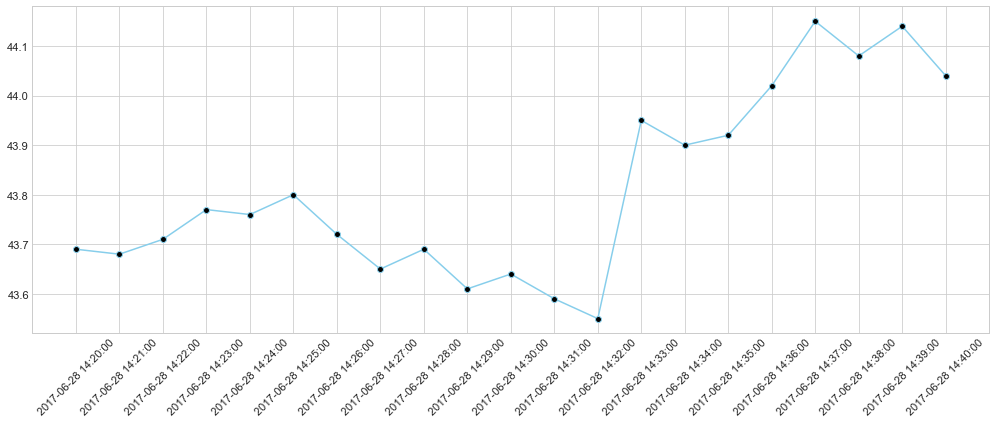

In [30]:
# Let's check data near '2017-06-28 14:32:00
fig, ax = plt.subplots(1, sharex=False, sharey=False)
plt.plot(series['2017-06-28 14:20:00':'2017-06-28 14:40:00'], color='skyblue', marker='o', mfc='k')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../Figs/lstm_anomaly2.pdf', dpi=300)

### Predict Future

This has nothing to do with anomaly detection. I am just curious to test the model in prediction of next n minutes from our last observation.

In [54]:
#our last observation
print (series.iloc[-1:])

Date_Time
2017-07-14 20:00:00    44.73
Name: APC, dtype: float64


In [55]:
# last value of our dataset
f = np.array(44.73)
# sklearn minmaxscaler for converting "f" to range to (-1,1)
scaler = MinMaxScaler(feature_range=(-1, 1))
# minmaxscaler fit
scaler = scaler.fit(f)
# let's transform
train = f.reshape(1, 1)
train_scaled = scaler.transform(train)

In [59]:
# initial record
initial = train_scaled
# store prediction
prediction = []
# range 20 because we want the prediction for next 20 minutes
n = 20
for i in range(n):
    # predict 
    yhat = forecast_lstm(lstm_model, 1, initial)
    # inverse prediction to it's original value
    yhat_inver = scaler.inverse_transform(yhat)
    # append to our prediction variable
    prediction.append(yhat_inver)
    # re initial our initial variable so that it feed the current predicted value as input for forecast
    initial = np.array([yhat])

In [60]:
prediction = np.concatenate(prediction, axis=0 ).tolist()
prediction = [item for sublist in prediction for item in sublist]
prediction = pd.DataFrame(prediction)

In [61]:
rng = pd.date_range('2017-07-15 13:30:00', periods=20, freq='T')
rng = pd.DataFrame(rng)
prediction = pd.merge(rng, prediction, left_index=True, right_index=True, how='outer')
prediction.set_index('0_x')
prediction.columns = ['Date_time', 'APC']
prediction

,Date_time,APC
0,2017-07-15 13:30:00,45.339947
1,2017-07-15 13:31:00,45.340469
2,2017-07-15 13:32:00,45.339851
3,2017-07-15 13:33:00,45.338970
4,2017-07-15 13:34:00,45.338161
5,2017-07-15 13:35:00,45.337551
6,2017-07-15 13:36:00,45.337170
7,2017-07-15 13:37:00,45.336983
8,2017-07-15 13:38:00,45.336956
9,2017-07-15 13:39:00,45.337044


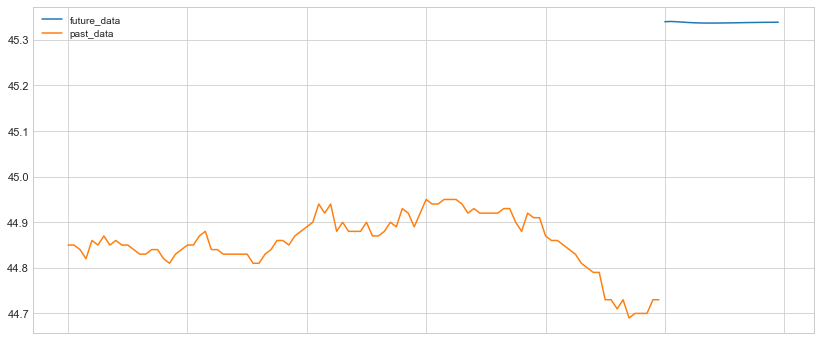

In [63]:
df1 = pd.DataFrame(prediction['APC'].values, index=prediction['Date_time'])
df1.columns = ['future_data']
df2 = pd.DataFrame(series[-100:])
df2.columns = ['past_data']
df = pd.concat([df2, df1])
df.plot()

It doesn't show much variation which suggests that this model is probably **useless**.